# Demo with several models and words

In [8]:
from huggingface_hub import login
from openai import OpenAI
import os
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import numpy as np


## Set-ups

In [5]:
os.environ["NEBIUS_API_KEY"] = "v1.CmMKHHN0YXRpY2tleS1lMDByNG13OHJlOTEwYXhtZjcSIXNlcnZpY2VhY2NvdW50LWUwMHZ2ZW53eDUwMDM1NTU1NjIMCOeCosgGEPu9g74COgsI54W6kwcQwMLuSkACWgNlMDA.AAAAAAAAAAF-s3IVuPd-6SwZfzos0vgqlAlUZtfge6Kj5JAVVepABWajqetR76LusvMMN1mo0E5Y5TbLdhzBkjxNaiMXxrQM"

In [6]:
MODEL_CONFIG = {
    "weak":   "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "avg":    "google/gemma-2-9b-it-fast",         
    "strong": "openai/gpt-oss-20b"
}

In [7]:
def build_model(model_name):
    return ChatOpenAI(
        base_url="https://api.studio.nebius.ai/v1",
        api_key=os.getenv("NEBIUS_API_KEY"),
        model=model_name,
        temperature=0.7
    )

models = { role: build_model(name) for role, name in MODEL_CONFIG.items() }

model_order = ["weak", "avg", "strong"]

In [ ]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

## Chain on a small dataset of words

In [9]:
def one_chain_block(model, chain, chain_desc):
    description = chain_desc[-1]
    guess = model.invoke([
        HumanMessage(
            f"You recieved this description: \"{description}\".\n"
            f"Guess the word. Reply with ONLY the guessed word."
        )
    ]).content.strip()

    chain.append(guess)

    # Person creates a NEW description based on:
    # 1) the description they heard
    # 2) their guessed word

    new_description = model.invoke([
        HumanMessage(
            f"You just heard this description: \"{description}\".\n"
            f"You guessed the word: \"{guess}\".\n"
            f"Create another description for your guessed word in ONLY 2 sentences."
            f"WITHOUT naming it directly."
        )
    ]).content

    chain_desc.append(new_description)

    return chain, chain_desc

In [14]:
def run_over_one_word(word, steps=1):
    chain = [word]
    chain_desc = []
    chain_models = ["avg"] 

    description = models["avg"].invoke([
        HumanMessage(f"Describe this word in 3 sentences without naming it: {word}.")
    ]).content
    chain_desc.append(description)

    for i in range(steps):
        for role in model_order:
            model = models[role]
            chain, chain_desc = one_chain_block(model, chain, chain_desc)
            chain_models.append(role)

    print(f"\n=== Results for word: {word} ===")
    for i, (w, d, role) in enumerate(zip(chain, chain_desc, chain_models)):
        print(f"--- Step {i} ({role}) ---")
        print(f"Word: {w}")
        print(f"Description:\n{d}\n")
    
    return chain, chain_desc, chain_models

# TODO implement the way to save the results, as a dictionary so I can save them as a json file.

## Evaluation

In [3]:
def word_semantic_similarity_decay(chain):
    """
    Computes W-SSD for each step in the chain.
    Returns a list of cosine similarities.
    """
    orig_emb = embedder.encode(chain[0], convert_to_tensor=True)
    sims = []

    for w in chain:
        w_emb = embedder.encode(w, convert_to_tensor=True)
        sim = util.cos_sim(orig_emb, w_emb).item()
        sims.append(sim)

    return sims

In [4]:
def description_semantic_similarity_decay(chain_desc):
    """
    Computes D-SSD for descriptions.
    Returns cosine similarity between D0 and each Dt.
    """
    orig_emb = embedder.encode(chain_desc[0], convert_to_tensor=True)
    sims = []
    
    for d in chain_desc:
        d_emb = embedder.encode(d, convert_to_tensor=True)
        sim = util.cos_sim(orig_emb, d_emb).item()
        sims.append(sim)

    return sims

In [16]:
def plot_w_ssd_d_ssd(word, chain, chain_desc):
    # compute metrics
    w_ssd = word_semantic_similarity_decay(chain)
    d_ssd = description_semantic_similarity_decay(chain_desc)

    steps = np.arange(len(w_ssd))

    plt.figure(figsize=(10, 6))

    # Word drift curve (usually noisier)
    plt.plot(steps, w_ssd, marker='o', linestyle='-', label='Word SSD (W-SSD)', linewidth=2)

    # Description drift curve (usually smoother / more stable)
    plt.plot(steps, d_ssd, marker='s', linestyle='--', label='Description SSD (D-SSD)', linewidth=2)

    # Horizontal drift thresholds (optional)
    plt.axhline(0.5, color='gray', linestyle=':', linewidth=1)
    plt.text(0, 0.51, "Drift threshold (0.5)", fontsize=9, color='gray')

    plt.title(f"Semantic Drift for '{word}'", fontsize=14)
    plt.xlabel("Chain Step", fontsize=12)
    plt.ylabel("Cosine Similarity to Original", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.show()


## Final Run

In [18]:
common_words = ['apple', 'cat', 'home', 'friend', 'jewelery']
rare_words = ['papaya', 'chinchilla', 'Laos', 'acquaintance', 'benitoite']

Common Word Experiment:


=== Results for word: apple ===
--- Step 0 (avg) ---
Word: apple
Description:
It's a round, crisp fruit with a sweet taste.  Many cultures enjoy it fresh, baked into pies, or pressed into juice. Its skin can range in color from vibrant red to a pale green.  




--- Step 1 (weak) ---
Word: Apple
Description:
This iconic fruit is often associated with autumn and is commonly used in a variety of sweet and savory dishes, from crisp salads to warm desserts. Its juicy flesh is a popular snack when eaten fresh, and its seeds are often pressed for oil that's prized for its flavor and nutritional benefits.

--- Step 2 (avg) ---
Word: Apple
Description:
Its skin can range from vibrant reds to pale yellows, often kissed with a blush of pink.  A simple slice, dipped in caramel, is a timeless treat. 




--- Step 3 (strong) ---
Word: Apple
Description:
It falls from the orchard with a crisp, sweet aroma, its skin a tapestry of glossy crimson and golden amber.  
Its bite yields a satisfying crunch

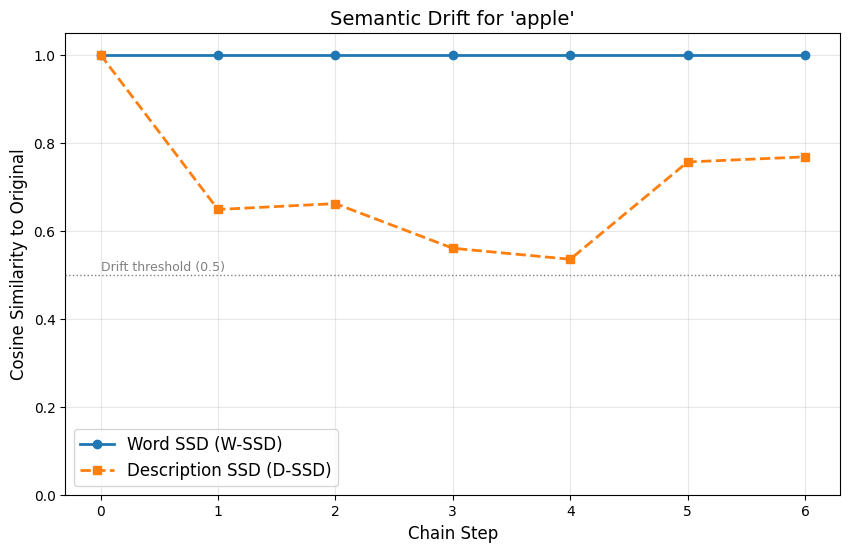


=== Results for word: cat ===
--- Step 0 (avg) ---
Word: cat
Description:
It's a furry, four-legged companion known for its purring and playful nature.  
This animal often has sharp claws and a keen sense of hearing.  
Popular as a household pet, it comes in a variety of colors and breeds.  




--- Step 1 (weak) ---
Word: Cat
Description:
This agile creature is known for its remarkable jumping ability and is often found lounging in sunbeams. With a short, smooth coat and a curious disposition, it is a popular companion for many people around the world.

--- Step 2 (avg) ---
Word: Cat
Description:
They purr with contentment when stroked, and their playful pounce can bring joy to any room.  A curious gaze and a love for high places are just some of their endearing traits. 




--- Step 3 (strong) ---
Word: cat
Description:
Soft paws tread silently across the floor, whiskers twitching at every new scent.  
With a gentle purr, they find comfort in human arms, yet they relish the height o

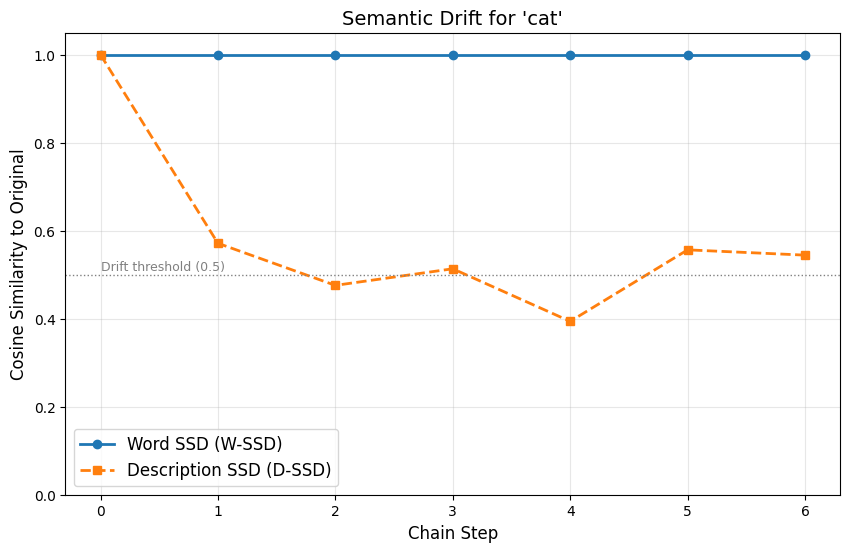


=== Results for word: home ===
--- Step 0 (avg) ---
Word: home
Description:
It's a place of warmth and comfort, offering refuge from the outside world.  

It holds memories, both joyful and sorrowful, woven into its walls and floors.  

It's a place where you can truly be yourself, loved and accepted for who you are. 




--- Step 1 (weak) ---
Word: Home
Description:
Here's another description for "Home" in 2 sentences:

It's a sanctuary where the heartbeat of the family is palpable, where laughter and tears are shared, and memories are forged. Its walls tell the story of countless moments, whispers, and secrets, and its warmth is a constant reminder of love and belonging.

--- Step 2 (avg) ---
Word: Family
Description:
Unbreakable bonds connect them, through thick and thin.  They are a source of unwavering support, laughter, and love, shaping each other's lives in profound ways. 




--- Step 3 (strong) ---
Word: friendship
Description:
It is the quiet companion that stands beside yo

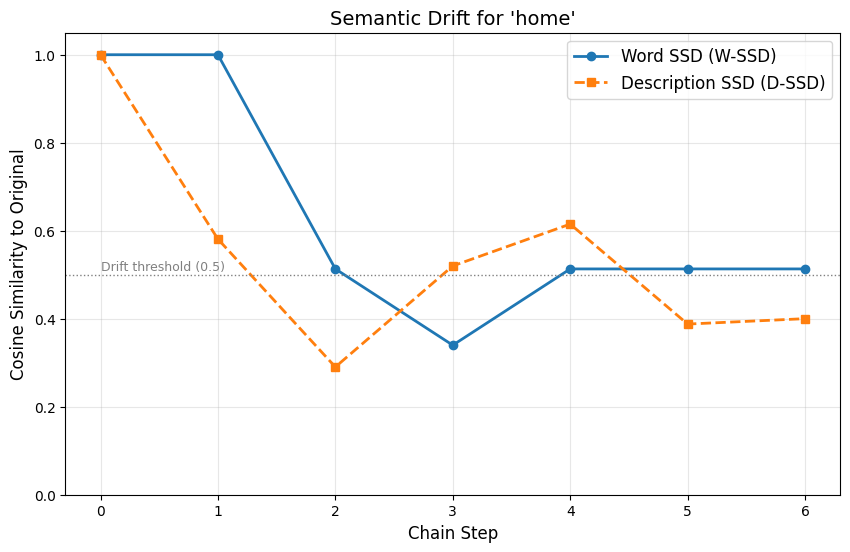


=== Results for word: friend ===
--- Step 0 (avg) ---
Word: friend
Description:
This person is someone you cherish and trust deeply. 

They bring joy and support to your life, celebrating your successes and offering comfort during tough times. 

Their presence makes the world a brighter place, and their bond is invaluable. 




--- Step 1 (weak) ---
Word: Family
Description:
Here is a description of the word:

They are a constant source of love, care, and protection, always there to offer a listening ear and a comforting hug. Their memories are etched in your heart, creating a lifetime of laughter, tears, and unforgettable moments.

--- Step 2 (avg) ---
Word: Parents
Description:
They shape your earliest understanding of the world, instilling values and guiding you through life's first steps. Though they may not always get it right, their love remains a constant, unwavering force. 




--- Step 3 (strong) ---
Word: Parents
Description:
They are the first teachers we encounter, shaping

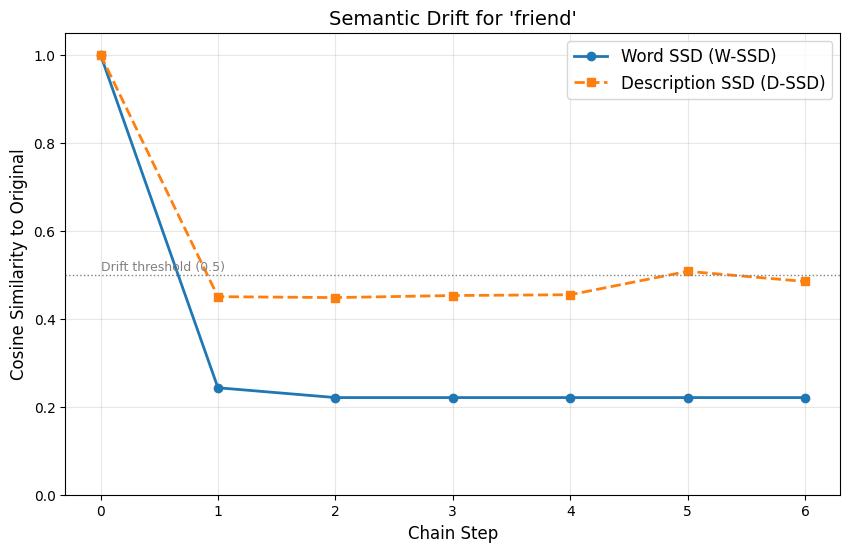


=== Results for word: jewellery ===
--- Step 0 (avg) ---
Word: jewellery
Description:
It adorns the body and often reflects personal style.  Made from a variety of materials, it can be both functional and decorative.  From simple earrings to elaborate necklaces, it has been prized for centuries as a symbol of wealth, status, and beauty. 





--- Step 1 (weak) ---
Word: Jewelry
Description:
This decorative adornment can be found in various forms, from subtle to bold, and often adorns the neck, ears, fingers, or wrists. Its allure has captivated people across cultures and time, symbolizing power, elegance, and individuality.

--- Step 2 (avg) ---
Word: Jewelry
Description:
It whispers stories of bygone eras and personal triumphs, each piece a unique testament to taste and style.  Worn with pride, it sparks admiration and illuminates the wearer's individuality. 




--- Step 3 (strong) ---
Word: jewelry
Description:
Adorned with precious metals and gemstones, it echoes the romance of ce

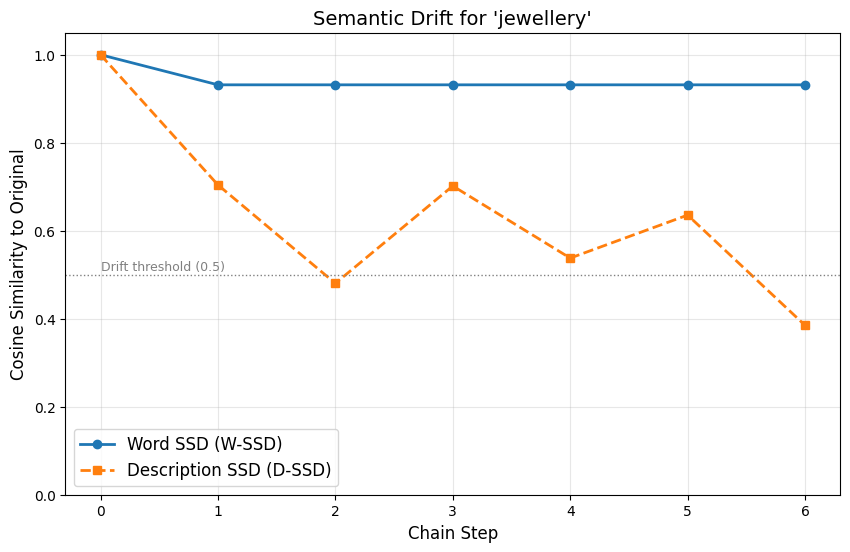

In [17]:
for word in common_words:
   chain, chain_desc, chain_models = run_over_one_word(word, 2)
   plot_w_ssd_d_ssd(word, chain, chain_desc)   


=== Results for word: papaya ===
--- Step 0 (avg) ---
Word: papaya
Description:
This tropical fruit is known for its bright orange flesh and sweet, slightly tangy flavor.  It has a large, oblong shape with a smooth, slightly bumpy skin.  This fruit is a good source of vitamins and enzymes, and is often eaten fresh or used in juices and desserts. 




--- Step 1 (weak) ---
Word: Pineapple
Description:
Here is a description for the word "Pineapple":

This prickly, tropical fruit has a tough, waxy exterior that protects its sweet and juicy interior, which can be easily cut into chunks and served as a snack. Its tough leaves and woody stem are often removed before consuming the fruit, which is a popular ingredient in Hawaiian cuisine.

--- Step 2 (avg) ---
Word: Pineapple
Description:
Its spiky crown hides a treasure of sweet, segmented flesh.  Often featured in tropical drinks and savory dishes, it's a symbol of the islands. 




--- Step 3 (strong) ---
Word: pineapple
Description:
A rug

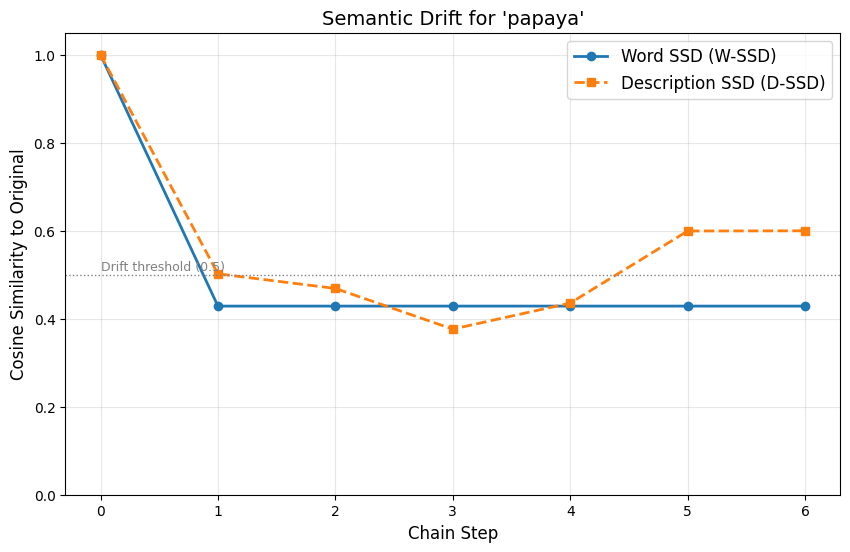


=== Results for word: chinchilla ===
--- Step 0 (avg) ---
Word: chinchilla
Description:
This small, fluffy creature is known for its incredibly dense fur.  It is a native of the Andes Mountains and thrives in arid, rocky environments.  This nocturnal animal is a popular pet due to its gentle nature and unique appearance.  




--- Step 1 (weak) ---
Word: Chinchilla
Description:
This soft, bushy-tailed rodent is a prized companion animal due to its calm demeanor and velvety coat. Its native South American habitat is characterized by rugged terrain and limited vegetation, where its specially adapted fur allows it to survive comfortably.

--- Step 2 (avg) ---
Word: Chinchilla
Description:
This creature's luxurious fur was once highly sought after, leading to near extinction.  Despite its delicate appearance, it thrives in harsh, arid environments with its unique physical adaptations.  




--- Step 3 (strong) ---
Word: Chinchilla
Description:
This small, nocturnal mammal native to the hi

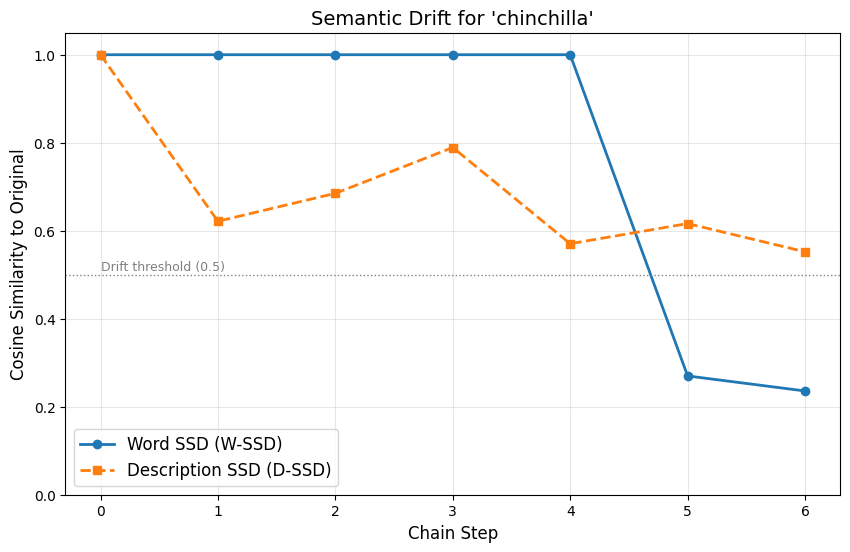


=== Results for word: Laos ===
--- Step 0 (avg) ---
Word: Laos
Description:
This Southeast Asian nation is known for its stunning natural beauty, from lush jungles to tranquil rivers.  Its history is rich with ancient temples and the legacy of French colonialism.  Today, it's a peaceful country welcoming visitors to experience its unique culture and laid-back atmosphere.  




--- Step 1 (weak) ---
Word: Cambodia
Description:
Here's a 2-sentence description of the country I guessed:

"Angkor Wat, one of the largest temple complexes in the world, is an iconic symbol of this country's ancient civilization. The tragic story of the Khmer Rouge's brutal regime still lingers in the collective memory of this nation, a somber reminder of its complex and often tumultuous past."

--- Step 2 (avg) ---
Word: Cambodia
Description:
This Southeast Asian nation is renowned for its stunning temples, remnants of a glorious empire that once stretched across the region.  Despite a harrowing period of pol

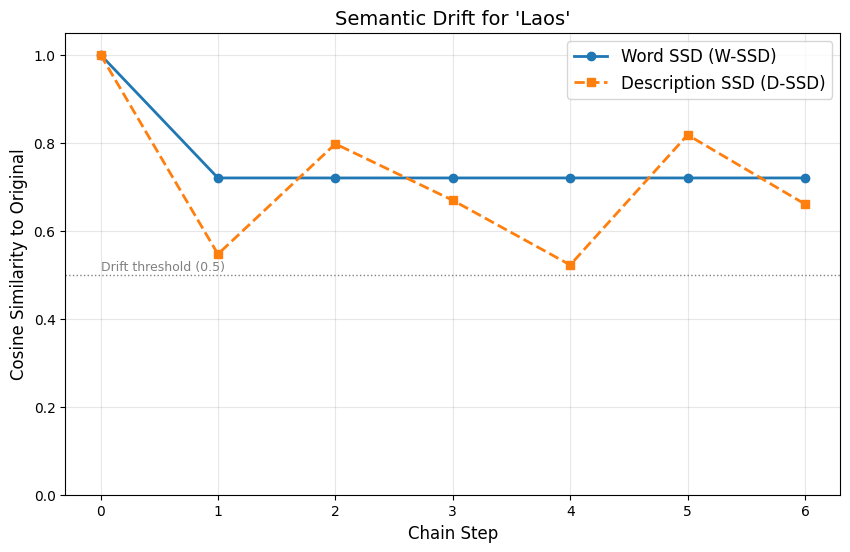


=== Results for word: acquaintance ===
--- Step 0 (avg) ---
Word: acquaintance
Description:
This term describes someone you know, but not well.  You may have had brief interactions or met them through a mutual friend.  It's a less intimate connection than a close friend or family member. 




--- Step 1 (weak) ---
Word: Acquaintance
Description:
Someone you might see frequently, but wouldn't typically consider them a close confidant or person with whom you share deep, personal experiences. You may exchange pleasantries or discuss surface-level topics, but your connection is generally superficial and doesn't involve a strong emotional bond.

--- Step 2 (avg) ---
Word: Acquaintance
Description:
You bump into them often, maybe even share a brief chat about the weather.  

But, genuine closeness or emotional vulnerability never crosses the line in your interactions. 





--- Step 3 (strong) ---
Word: acquaintance
Description:
You exchange polite greetings at the coffee shop during the wo

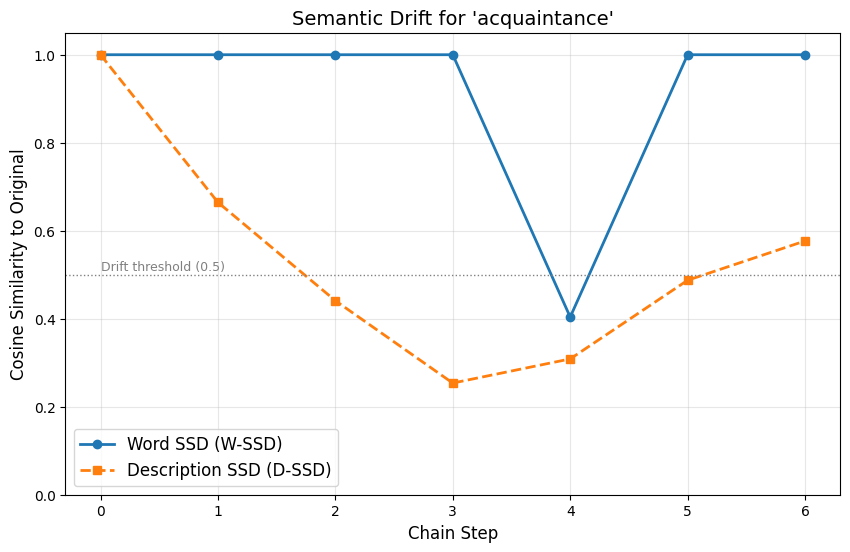


=== Results for word: benitoite ===
--- Step 0 (avg) ---
Word: benitoite
Description:
This rare gemstone is found in only one place on Earth. Its vibrant, electric blue color is caused by the presence of a specific element. It shines with a captivating brilliance, making it a prized possession for collectors. 




--- Step 1 (weak) ---
Word: Benitoite
Description:
This gemstone, discovered in limited quantities, is prized for its soft, serene blue hue and its relatively low hardness compared to other gemstones. It is found in only a few locations on Earth, with the majority of known specimens originating from a single mine in the western United States.

--- Step 2 (avg) ---
Word: Turquoise
Description:
Often set in silver, this stone's vibrant blue-green color has been cherished for centuries by many cultures.  Its healing properties and connection to ancient traditions make it a popular choice for jewelry and spiritual adornment. 




--- Step 3 (strong) ---
Word: turquoise
Descripti

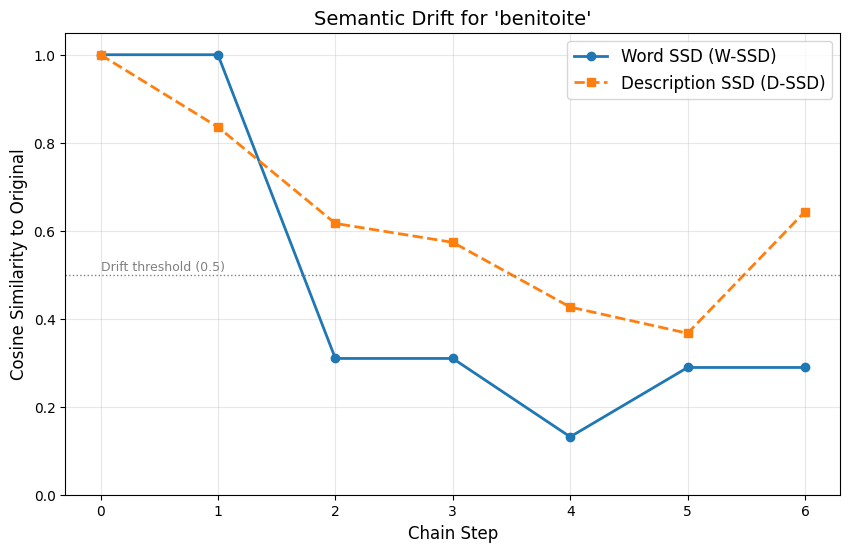

In [19]:
for word in rare_words:
   chain, chain_desc, chain_models = run_over_one_word(word, 2)
   plot_w_ssd_d_ssd(word, chain, chain_desc)   